In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
data = pd.read_pickle("C:/1. Power grid frequency data/df_South_Korea_cleansed_2024-08-15_2024-12-10.pkl")

data.index = pd.to_datetime(data.index)

# Step 1: Filter for rows where QI == 0 and no NaN in any relevant column
data_filtered = data[(data['QI'] == 0) & (data['freq'].notna())].dropna()

# Recheck for NaN
print("NaN Summary after filtering for QI and freq in data_filtered:")
print(data_filtered.isna().sum())

# Step 2: Group the data by the hour
hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))

# Step 3: Filter out incomplete hours 
valid_hours = hourly_groups.filter(lambda x: len(x) == 3600)

# Step 4: Extract the 'freq' column and add a 'Time' column
valid_hours['Time'] = valid_hours.index  #
freq = valid_hours['freq']

# Validate that valid_hours is a multiple of 3600
print(f"Total rows in valid_hours: {len(valid_hours)}")
print(f"Is valid_hours a multiple of 3600? {len(valid_hours) % 3600 == 0}")


# Delete QI column and convert frequency to omega and add 'omega' column
valid_hours.drop(columns=['QI'], inplace=True)
valid_hours['omega'] = 2 * np.pi * (valid_hours['freq'] - 60)

# Look the first 10 rows of valid_hours
print(valid_hours.head(10))
len(valid_hours)/3600


NaN Summary after filtering for QI and freq in data_filtered:
freq    0
QI      0
dtype: int64


C:\Users\wp7528\AppData\Local\Temp\ipykernel_24060\3601689702.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))


Total rows in valid_hours: 8823600
Is valid_hours a multiple of 3600? True
                          freq                Time     omega
2024-08-15 01:00:00  59.974473 2024-08-15 01:00:00 -0.160393
2024-08-15 01:00:01  59.975651 2024-08-15 01:00:01 -0.152990
2024-08-15 01:00:02  59.977579 2024-08-15 01:00:02 -0.140874
2024-08-15 01:00:03  59.976437 2024-08-15 01:00:03 -0.148052
2024-08-15 01:00:04  59.974978 2024-08-15 01:00:04 -0.157216
2024-08-15 01:00:05  59.973959 2024-08-15 01:00:05 -0.163623
2024-08-15 01:00:06  59.977355 2024-08-15 01:00:06 -0.142285
2024-08-15 01:00:07  59.976714 2024-08-15 01:00:07 -0.146311
2024-08-15 01:00:08  59.977276 2024-08-15 01:00:08 -0.142779
2024-08-15 01:00:09  59.978177 2024-08-15 01:00:09 -0.137119


2451.0

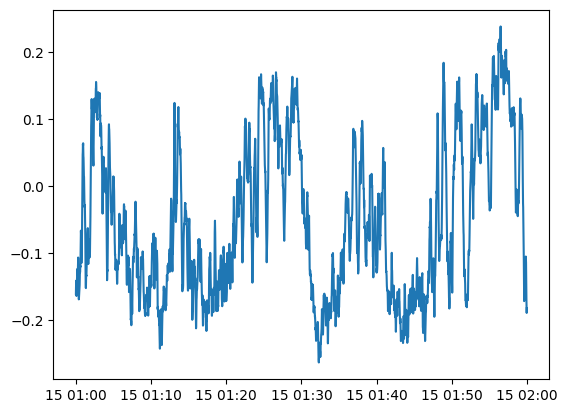

In [7]:
# Plot the omega data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])

In [5]:
def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data


In [7]:
from scipy.integrate import cumtrapz

def integrate_data(omega_data, dt=1, initial_theta=0):
    theta_data = cumtrapz(omega_data, dx=dt, initial=initial_theta)
    return theta_data

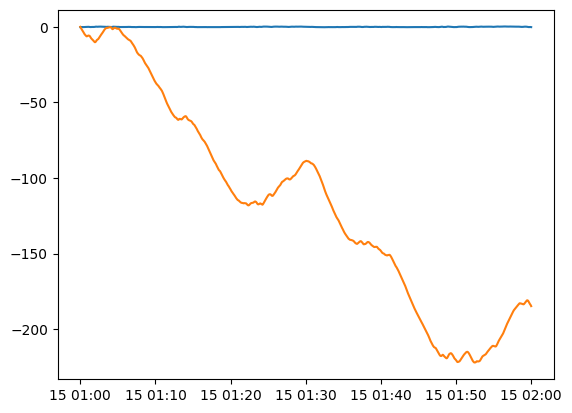

In [8]:
# Integrate the omega data and call it theta and add 'theta' column
valid_hours['theta'] = integrate_data(valid_hours['omega'],1)
# Plot the omega and theta data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])
plt.plot(valid_hours['theta'][0:3600])

In [6]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, region_name, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with the specified region name
        chunk['Region'] = region_name
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with the specified region name
        remaining_chunk['Region'] = region_name
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data

In [7]:
# Apply Gaussian filter to the omega data
filtered_data = apply_gaussian_filter(valid_hours['omega'], 'South Korea')

# Check the number of chunks created
print(f"Number of chunks created: {len(filtered_data)}")
filtered_data

Number of chunks created: 2451


[                        omega  omega_filtered       Region
 2024-08-15 01:00:00 -0.160393       -0.086092  South Korea
 2024-08-15 01:00:01 -0.152990       -0.086075  South Korea
 2024-08-15 01:00:02 -0.140874       -0.086040  South Korea
 2024-08-15 01:00:03 -0.148052       -0.085989  South Korea
 2024-08-15 01:00:04 -0.157216       -0.085920  South Korea
 ...                       ...             ...          ...
 2024-08-15 01:59:55 -0.153148       -0.015374  South Korea
 2024-08-15 01:59:56 -0.168694       -0.015464  South Korea
 2024-08-15 01:59:57 -0.177234       -0.015531  South Korea
 2024-08-15 01:59:58 -0.188864       -0.015576  South Korea
 2024-08-15 01:59:59 -0.181731       -0.015599  South Korea
 
 [3600 rows x 3 columns],
                         omega  omega_filtered       Region
 2024-08-15 02:00:00 -0.170663       -0.021602  South Korea
 2024-08-15 02:00:01 -0.162034       -0.021608  South Korea
 2024-08-15 02:00:02 -0.148849       -0.021621  South Korea
 2024-08-15 

In [8]:
from sklearn.metrics import explained_variance_score, max_error

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = {}
    scores = {}

    transformations = {
        "linear_time": lambda chunk: np.arange(0, len(chunk), 1).reshape(-1, 1),
        "exp_1000": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
        #"exp_3600": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 3600) - 1).reshape(-1, 1),

        # Sine transformation of time
        #"sin_time": lambda chunk: np.sin((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
        
        # Cosine transformation of time
        #"cos_time": lambda chunk: np.cos((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
    }

    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        scores[transform_name] = []

        for chunk in region_data:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            
            # Apply the selected time transformation
            t_train_chunk = transform_func(chunk)

            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            
            feature_names_chunk = ["theta", "omega", "time"]
            polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
            sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
            
            model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                                   feature_library=polynomial_library_chunk,
                                   optimizer=sparse_regression_optimizer_chunk)
            
            model_chunk.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model_chunk)
            
            # Compute the explained variance score
            score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name].append(score)

        # Compute the mean score for this transformation
        mean_score = np.mean(scores[transform_name])
        print(f"Mean Model Score for {region_name} using {transform_name}: {mean_score}")

    return sindy_models, scores


In [10]:
# Calculate the sindy models and scores with different n values

sindy_models_n1, scores_n1 = calculate_model_scores(filtered_data, 'South Korea', n=1)
sindy_models_n2, scores_n2 = calculate_model_scores(filtered_data, 'South Korea', n=2)
sindy_models_n3, scores_n3 = calculate_model_scores(filtered_data, 'South Korea', n=3)

Mean Model Score for South Korea using linear_time: 0.4048262846718111
Mean Model Score for South Korea using exp_1000: 0.7178612527512411
Mean Model Score for South Korea using linear_time: 0.48315214251885213
Mean Model Score for South Korea using exp_1000: 0.8162918064759801
Mean Model Score for South Korea using linear_time: 0.5526602393660828
Mean Model Score for South Korea using exp_1000: 0.9014818954573988


In [69]:
#sindy_models['exp_1000'][0].coefficients()
# get the mean coefficient of features
def get_mean_coefficients(sindy_models):
    mean_coefficients = {}
    for transform_name, models in sindy_models.items():
        mean_coefficients[transform_name] = np.mean([model.coefficients() for model in models], axis=0)
    return mean_coefficients



In [71]:
mean_coefficients = get_mean_coefficients(sindy_models)


feature_names = sindy_models['exp_1000'][0].get_feature_names()


for transform_name, coeff_matrix in mean_coefficients.items():
    print(f"Transform: {transform_name}")
      
    for eq_idx, coefficients in enumerate(coeff_matrix):
        print(f"  Equation {eq_idx + 1}:")
               
        for feature, coef in zip(feature_names, coefficients):
            print(f"    {feature}: {coef:.6e}") 


Transform: exp_1000
  Equation 1:
    1: 2.531413e-06
    theta: -9.259120e-08
    omega: 9.999207e-01
    time: 4.253807e-08
    theta^2: 7.148297e-10
    theta omega: 2.232606e-07
    theta time: -1.612538e-09
    omega^2: 1.617917e-04
    omega time: -5.168311e-06
    time^2: 2.354993e-08
    theta^3: 1.344602e-11
    theta^2 omega: -1.843642e-08
    theta^2 time: -5.828799e-11
    theta omega^2: 5.867185e-07
    theta omega time: 7.374280e-08
    theta time^2: 1.098082e-10
    omega^3: -9.048247e-04
    omega^2 time: 1.386052e-06
    omega time^2: -4.067124e-07
    time^3: -3.104675e-10
  Equation 2:
    1: -2.864220e-05
    theta: -5.113040e-05
    omega: -1.676107e-03
    time: 9.791005e-04
    theta^2: 1.031473e-07
    theta omega: 3.221363e-05
    theta time: -1.854835e-05
    omega^2: -1.999876e-03
    omega time: -6.111457e-04
    time^2: 3.812156e-05
    theta^3: -2.569559e-08
    theta^2 omega: -1.858267e-07
    theta^2 time: 7.766383e-08
    theta omega^2: -5.551334e-04
  

In [78]:
feature_names_list = list(feature_names)

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2',
 'theta^3',
 'theta^2 omega',
 'theta^2 time',
 'theta omega^2',
 'theta omega time',
 'theta time^2',
 'omega^3',
 'omega^2 time',
 'omega time^2',
 'time^3']

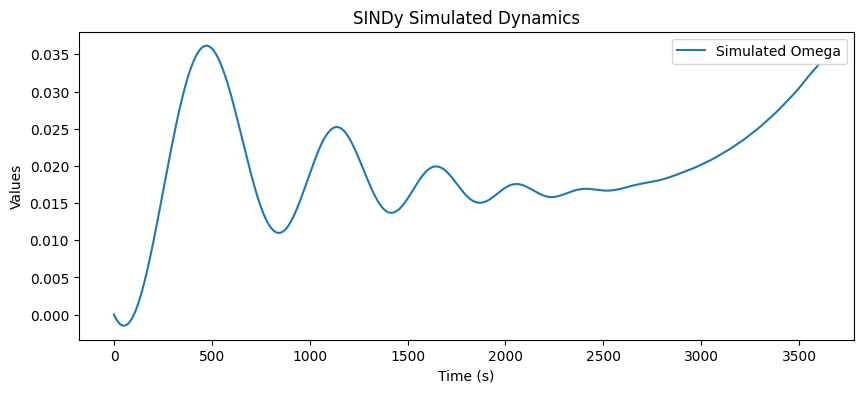

In [96]:
import numpy as np
from scipy.integrate import solve_ivp

def simulate_system(mean_coefficients, initial_conditions, t_span, feature_names):
   
    transform_name = "exp_1000"  # Choose transformation to simulate
    coeff_matrix = mean_coefficients[transform_name]

    def system_dynamics(t, state):
        theta, omega, time = state  # Extract variables
        derivatives = np.zeros_like(state)

        # Construct feature vector dynamically from feature_names
        feature_values = [1]  # Bias term (constant)
        for feature in feature_names:
            if feature == "theta":
                feature_values.append(theta)
            elif feature == "omega":
                feature_values.append(omega)
            elif feature == "time":
                feature_values.append(time)
            elif feature == "theta^2":
                feature_values.append(theta**2)
            elif feature == "omega^2":
                feature_values.append(omega**2)
            elif feature == "theta omega":
                feature_values.append(theta * omega)
            elif feature == "theta time":
                feature_values.append(theta * time)
            elif feature == "omega time":
                feature_values.append(omega * time)
            elif feature == "time^2":
                feature_values.append(time**2)
            elif feature == "theta^3":
                feature_values.append(theta**3)
            elif feature == "theta^2 omega":
                feature_values.append(theta**2 * omega)
            elif feature == "theta^2 time":
                feature_values.append(theta**2 * time)
            elif feature == "theta omega^2":
                feature_values.append(theta * omega**2)
            elif feature == "theta omega time":
                feature_values.append(theta * omega * time)
            elif feature == "theta time^2":
                feature_values.append(theta * time**2)
            elif feature == "omega^3":
                feature_values.append(omega**3)
            elif feature == "omega^2 time":
                feature_values.append(omega**2 * time)
            elif feature == "omega time^2":
                feature_values.append(omega * time**2)
            elif feature == "time^3":
                feature_values.append(time**3)

        feature_values = np.array(feature_values)  # Convert to NumPy array

        for eq_idx in range(len(state)):  # Iterate over theta_dot, omega_dot, and time_dot
            eq_coeffs = coeff_matrix[eq_idx]

            # Ensure feature_values and eq_coeffs have matching shapes
            if len(eq_coeffs) != len(feature_values):
                raise ValueError(
                    f"Mismatch: {len(eq_coeffs)} coefficients, but {len(feature_values)} features."
                )

            # Compute derivative using feature coefficients
            derivatives[eq_idx] = np.dot(eq_coeffs, feature_values)

        return derivatives

    # Solve ODE
    sol = solve_ivp(system_dynamics, (t_span[0], t_span[-1]), initial_conditions, t_eval=t_span)

    return sol.t, sol.y[0], sol.y[1], sol.y[2]  # Return time, theta, omega

# Extract feature names from SINDy
feature_names = sindy_models['exp_1000'][0].get_feature_names()


t_span = np.linspace(0, 3600*1, 1000)  # Simulate for one hour
initial_conditions = [0, 0, 0]  # Assume initial theta = 0, omega = 0, time = 0

sim_time, sim_theta, sim_omega, sim_t = simulate_system(mean_coefficients, initial_conditions, t_span, feature_names)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
#plt.plot(sim_time, sim_theta, label="Simulated Theta")
plt.plot(sim_time, sim_omega, label="Simulated Omega")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.legend()
plt.title("SINDy Simulated Dynamics")
plt.show()

In [36]:
exp_1000 = scores['exp_1000']
exp_3600 = scores['exp_3600']


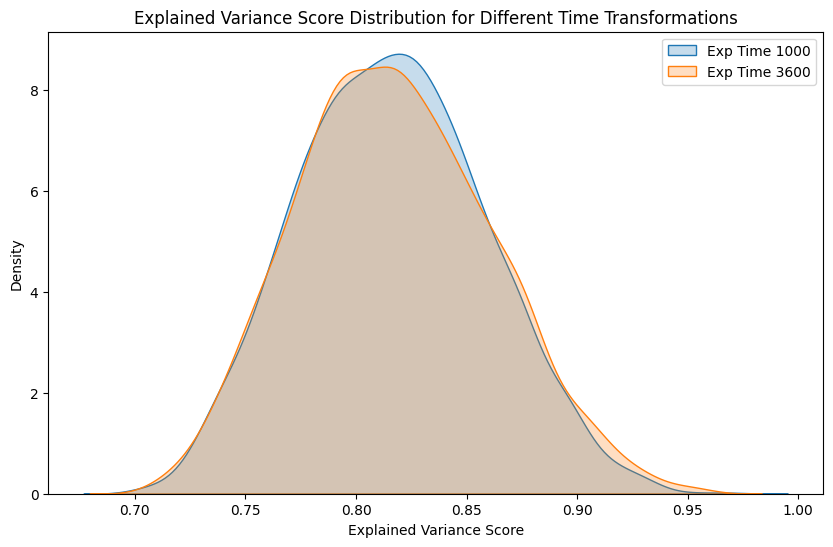

In [38]:
# plot the score with probability density function
plt.figure(figsize=(10, 6))
sns.kdeplot(exp_1000, label='Exp Time 1000', fill=True)
sns.kdeplot(exp_3600, label='Exp Time 3600', fill=True)

plt.xlabel('Explained Variance Score')
plt.ylabel('Density')
plt.title('Explained Variance Score Distribution for Different Time Transformations')
plt.legend()
plt.show()





In [39]:
# find out the maximum score and lowest score for each transformation
max_score = {}
min_score = {}
for key in scores.keys():
    max_score[key] = max(scores[key])
    min_score[key] = min(scores[key])

print("Maximum Scores for each transformation:")
print(max_score)
print("\nMinimum Scores for each transformation:")
print(min_score)

# find out the chunk index of the maximum score and lowest score for each transformation
max_score_index = {}
min_score_index = {}
for key in scores.keys():
    max_score_index[key] = scores[key].index(max_score[key])
    min_score_index[key] = scores[key].index(min_score[key])

print("Chunk Index of Maximum Scores for each transformation:")
print(max_score_index)
print("\nChunk Index of Minimum Scores for each transformation:")
print(min_score_index)

# find out the chunk index of second maximum score for each transformation
second_max_score_index = {}
for key in scores.keys():
    scores_copy = scores[key].copy()
    scores_copy.remove(max_score[key])
    second_max_score_index[key] = scores_copy.index(max(scores_copy))
print("\nChunk Index of Second Maximum Scores for each transformation:")
print(second_max_score_index)








Maximum Scores for each transformation:
{'exp_1000': 0.9687296054391852, 'exp_3600': 0.955938450313598}

Minimum Scores for each transformation:
{'exp_1000': 0.7033157844610703, 'exp_3600': 0.7071472372255103}
Chunk Index of Maximum Scores for each transformation:
{'exp_1000': 955, 'exp_3600': 1447}

Chunk Index of Minimum Scores for each transformation:
{'exp_1000': 867, 'exp_3600': 283}

Chunk Index of Second Maximum Scores for each transformation:
{'exp_1000': 933, 'exp_3600': 1410}


In [48]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [ ]:
sindy_models['diff_omega']

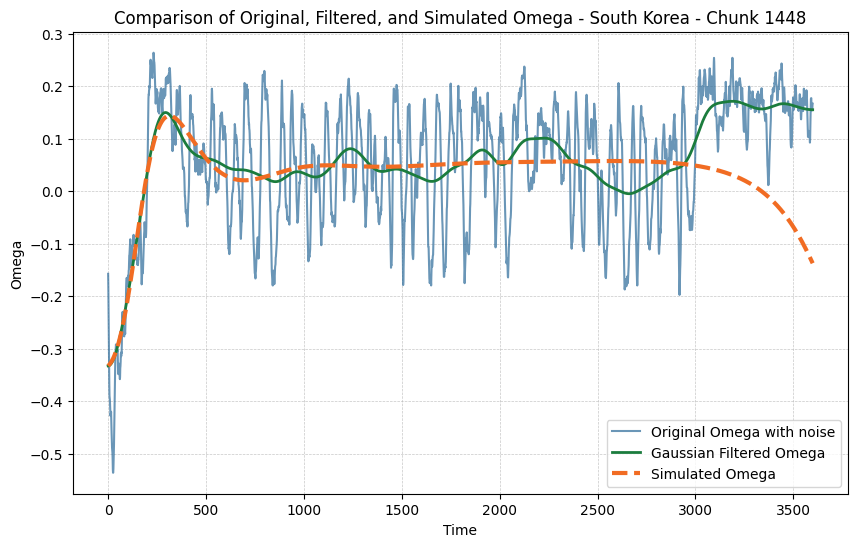

In [42]:
n = 1447
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 17)
simulate_sindy_model(sindy_models['exp_3600'][n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [ ]:
# use the mean coefficients to simulate the model
 

In [24]:
def plot_coefficients_for_regions(region_data, feature_names):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    markers = ['o', 's', '^']
    region_names = list(region_data.keys())
    n_regions = len(region_names)
    bar_width = 0.2  # Width of space to allocate to each region's marker

    # Calculate the total width occupied by all the regions' markers
    total_width = bar_width * n_regions

    # Calculate the offset to center the feature names
    center_offset = total_width / 2 - bar_width / 2

    region_colors = {'South Korea': '#1b9e77'}

    for region_name, data in region_data.items():
        means, stds = data['means'], data['stds']
        n_features = means.shape[1]
        
        # Select the marker for the region
        marker = markers[region_names.index(region_name) % len(markers)]
        region_offset = bar_width * region_names.index(region_name)

        for i in range(n_features):
            # Apply offset for each region to center the markers
            ax.errorbar(i + region_offset, np.abs(means[1, i]), yerr=stds[1, i], fmt=marker, label=region_name if i == 0 else "", color=region_colors[region_name])

    ax.legend(fontsize=16, title_fontsize=16, frameon=False)
    ax.set_xticks(np.arange(n_features) + center_offset)
    ax.set_xticklabels(feature_names, fontsize=16)
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.set_xlabel("Feature Candidates", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title("Coefficients with Error Bars for South Korea", fontsize=20)
    
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    
    return ax  # Return the ax object

<Axes: title={'center': 'Coefficients with Error Bars for South Korea'}, xlabel='Feature Candidates', ylabel='Coefficient Value'>

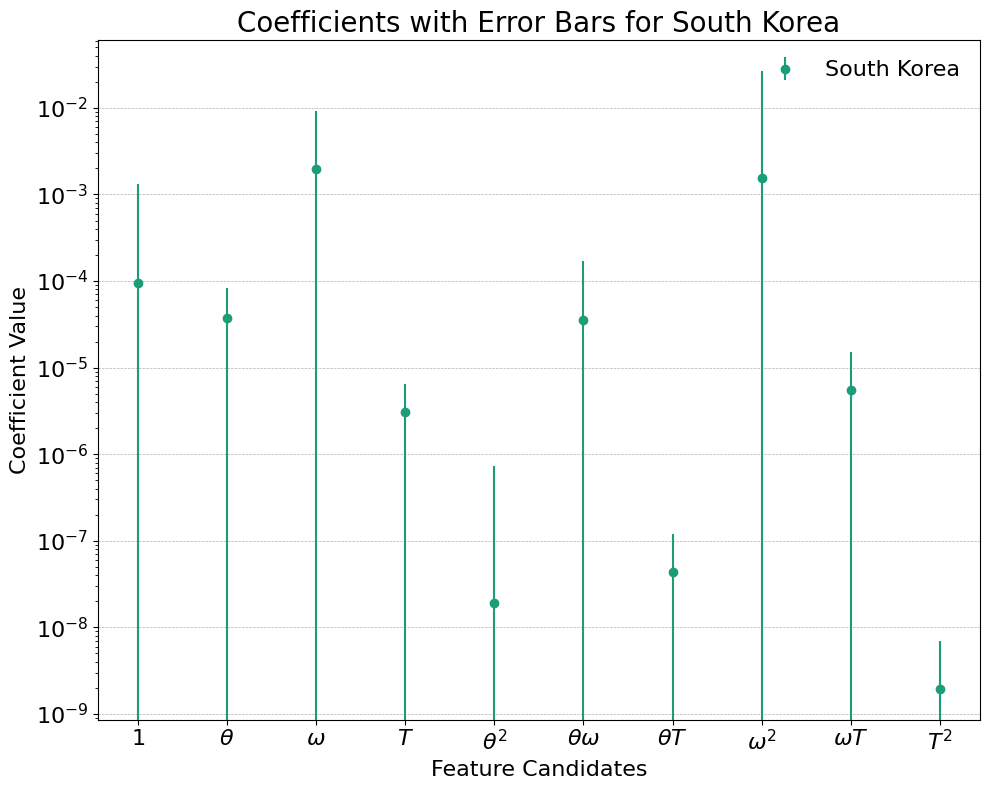

In [26]:
feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$T$', 
                r'$\theta^2$', r'$\theta\omega$', r'$\theta T$', r'$\omega^2$', 
                r'$\omega T$',r'$T^2$']
#apply plot_coefficients_for_regions function for South Korea
plot_coefficients_for_regions({'South Korea': {'means': skmean, 'stds': skstd}}, feature_names)